<a href="https://colab.research.google.com/github/Nikhileswar-Komati/Deep-Learning/blob/master/Copy_of_VIOLENCE_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nikhileswarkomati","key":"e75f0f971ce7ce2b2bc748fa02cbafd1"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset -p /content

100% 3.58G/3.58G [01:05<00:00, 50.0MB/s]



In [0]:
!unzip \*.zip

In [0]:
!pip install keras-video-generators

In [26]:
import keras
from keras_video import VideoFrameGenerator
# use sub directories names as classes
classes = ['Violence', 'NonViolence']
classes.sort()
# some global params
SIZE = (112, 112)
CHANNELS = 3
NBFRAME = 8
BS = 8
# pattern to get videos and classes
glob_pattern = '/content/Real Life Violence Dataset/{classname}/*'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.2,
    rotation_range=8,
    width_shift_range=.1,
    height_shift_range=.1)
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.10, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

class NonViolence, validation count: 100, train count: 900
class Violence, validation count: 100, train count: 900
Total data: 2 classes for 1800 files for train


In [27]:
valid = train.get_validation_generator()

Total data: 2 classes for 200 files for validation


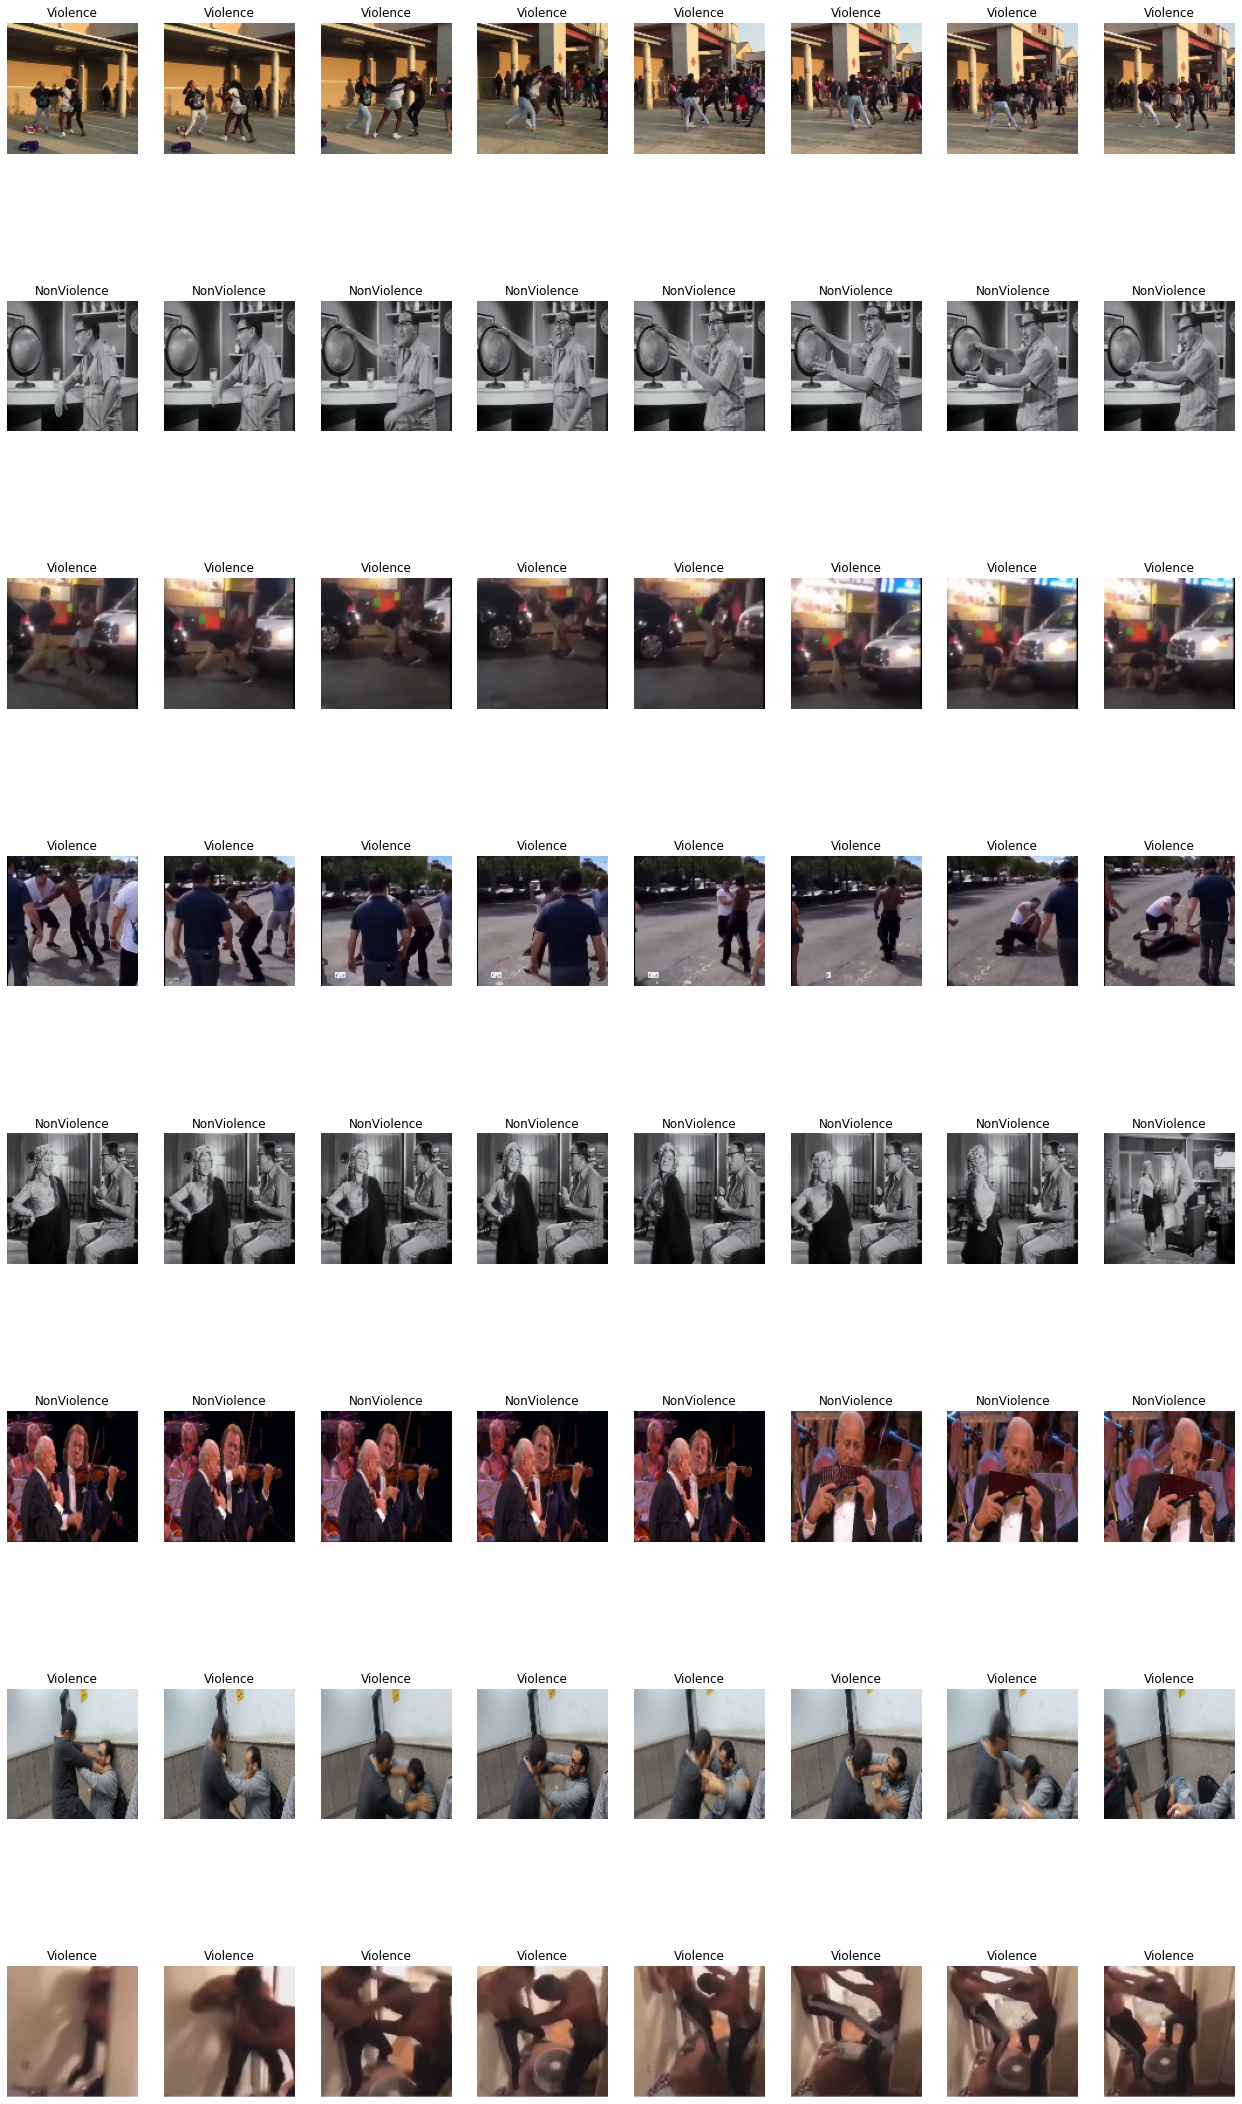

In [28]:
import keras_video.utils
keras_video.utils.show_sample(valid)

In [0]:
from keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D
def build_convnet(shape=(112, 112, 3)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model

In [0]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout
def action_model(shape=(8, 112, 112, 3), nbout=2):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.25))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [0]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
model = action_model(INSHAPE, 2)
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    optimizer,
    'binary_crossentropy',
    metrics=['acc']
)

In [33]:
!mkdir chkp
EPOCHS=50
# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        'chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]
model.fit_generator(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)

mkdir: cannot create directory ‘chkp’: File exists
Epoch 1/50
189/225 [========================>.....] - ETA: 1:14 - loss: 0.6925 - acc: 0.5708

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 50 could not be retrieved. It could be because a worker has died.
  UserWarning)


225/225 [==============================] - 557s 2s/step - loss: 0.6936 - acc: 0.5589 - val_loss: 0.6483 - val_acc: 0.6700

Epoch 00001: saving model to chkp/weights.01-0.65.hdf5
Epoch 2/50
225/225 [==============================] - 52s 232ms/step - loss: 0.6700 - acc: 0.6072 - val_loss: 0.5576 - val_acc: 0.6950

Epoch 00002: saving model to chkp/weights.02-0.56.hdf5
Epoch 3/50
225/225 [==============================] - 53s 235ms/step - loss: 0.6591 - acc: 0.6244 - val_loss: 0.6539 - val_acc: 0.6600

Epoch 00003: saving model to chkp/weights.03-0.65.hdf5
Epoch 4/50
225/225 [==============================] - 53s 237ms/step - loss: 0.6449 - acc: 0.6422 - val_loss: 0.6411 - val_acc: 0.6650

Epoch 00004: saving model to chkp/weights.04-0.64.hdf5
Epoch 5/50
225/225 [==============================] - 53s 234ms/step - loss: 0.6591 - acc: 0.6089 - val_loss: 0.6224 - val_acc: 0.6000

Epoch 00005: saving model to chkp/weights.05-0.62.hdf5
Epoch 6/50
225/225 [==============================] - 52s 